<a href="https://colab.research.google.com/github/Shuji-Ishikawa/final_project/blob/main/22001504_qmacro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):
    # Function to implement Tauchen's method for discretizing a continuous state space
    # Inputs:
    # n: number of grid points
    # mu: mean of the AR(1) process
    # rho: AR(1) coefficient
    # sigma: standard deviation of the error term
    # Outputs:
    # transition_matrix: n x n transition matrix
    # state_space: n x 1 vector of state space points

    m = 1 / np.sqrt(1 - rho**2)

    # Compute the state space
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # Compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n - 1)

    # Compute the transition probabilities
    transition_matrix = np.zeros((n, n))
    for i in range(n): # today state
        for j in range(n): # tomorrow state
            if j == 0: # prob going to the lower limit
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1: # prob going to the upper limit
                transition_matrix[i, j] = 1 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                z_low = (state_space[j] - rho*state_space[i] - d/2) / sigma # the lower bound
                z_high = (state_space[j] - rho*state_space[i] + d/2) / sigma # the higher bound
                transition_matrix[i, j] = norm.cdf(z_high) - norm.cdf(z_low)

    return transition_matrix, state_space

In [47]:
import numpy as np

# function to comile parameters into one thing "parameter"
def setPar(
    sigma = 1.50, # risk aversion
    beta = 0.98, # subjective discount factor
    delta = 0.03, # depreciation
    alpha = 0.25, # capital’s share of income
    rho = 0.6, # labor productivity persistence
    a_l = 0, # lower bound of asset grids
    a_u = 20, # upper bound of asset grids
    NH = 2, # number of grids of h
    NA = 401, # number of grids of a
    ):

    # labor productivity variance.
    sigma_eps = np.sqrt(0.6*(1-rho**2))

    # making grids for ln h and solving for income transition probability using Tauchen's method.
    pi, h = tauchen(NH, -0.7, rho, sigma_eps)
    h = np.exp(h) # changing ln h grids to h grids

    # derive the stationary distribution from income transition process

    probst = np.ones((NH))/NH # setting the guess probability to a uniform distribution
    test = 10.0 # initialize the distance to a big number

    while test > 1e-8: # loop until convergence of the stationary distribution
        probst_new = np.zeros((NH)) # initialize new distribution
        for ih in range(NH): # today h
            for ihp in range(NH): # tomorrow h
                probst_new[ihp] += pi[ih, ihp]*probst[ih]

        test = np.max(np.abs(probst_new - probst)) # calculate the difference between the guess and the new distribution
        probst = probst_new # updating the guess

    HH = np.sum(h*probst) # aggregate effective labor

	  # create dictionary with parameters
    param = {}
    param['sigma'] = sigma; param['beta'] = beta; param['delta'] = delta;
    param['alpha'] = alpha; param['probst'] = probst;
    param['a_l'] = a_l; param['a_u'] = a_u; param['NH'] = NH; param['NA'] = NA;
    param['pi'] = pi; param['h'] = h; param['HH'] = HH;

    return param


In [48]:
def solve_household_gs(param, r, w):

    # opening the box of "param" to some parameters
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi']; delta = param['delta'];
    beta = param['beta']; sigma = param['sigma']; h = param['h']; NA = param['NA'];
    NH = param['NH'];

    # Create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize the utility function to a large negative number for zero or negative consumption
    util = np.full((NA, NA, NH), -10000.0)

    # Calculate utility if the agent chooses asset a[iap] for each asset combination a[ia] and income shock h[ih]
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)


    # Initialize some variables
    v = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus_new = np.full((NA, NH), -10000)
    iaplus = np.full((NA, NH), -10000)
    reward = np.zeros((NA, NA, NH))

    # Iterate on Bellman's equation and get the decision rules and the value function at the optimum
    test = 10
    while test != 0: # loop until policy function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

        # Finding max of reward
        for ia in range(NA):
            for ih in range(NH):
                v_new[ia, ih] = np.max(reward[:, ia, ih]) # finding the maximal value
                iaplus_new[ia, ih] = np.argmax(reward[:, ia, ih]) # finding the index of the maximizer

        test = np.max(iaplus_new - iaplus) # stop if iaplus converges
        v = v_new
        iaplus = iaplus_new.copy()

    aplus = a[iaplus]

    # optimal consumption
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

In [49]:
def get_distribution(param, decisions):

    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi'];
    NA = param['NA']; NH = param['NH'];
    iaplus = decisions[1]

    # Generate a linearly spaced vector of NA values between a_l and a_u
    a = np.linspace(a_l, a_u, NA)

    test = 10 # Initialize a test value to be greater than 10^-8
    phi = np.ones((NA, NH)) / NA / NH # Initialize the distribution phi to be uniform

    # Loop until the test value is less than 10^-8
    while test > 1e-8:
        phi_new = np.zeros((NA, NH)) # Initialize a new distribution phi_new to be all zeros
        # Loop over all values of a, h, and h'
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    # Update phi_new using the interpolation indices, blending coefficients, and probabilities
                    phi_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * phi[ia, ih]
        test = np.max(np.abs(phi_new - phi)) # Calculate the maximum difference between phi_new and phi
        phi = phi_new # Update phi to be phi_new

    return phi

In [50]:
def model_solution(param):

    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH']

    phi = 0.2 # updating share
    toler = 1e-3 # warning: this doens't converge if tolerance is too small
    test = 10 # initial difference
    KK = 10.0 # initial capital

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:

        # Step 1
        # calculate rental rate of capital and w from firm FOC

        w = (1-alpha) * KK**(alpha) * HH**(-alpha)
        r = (alpha) * KK**(alpha-1) * HH**(1-alpha) - delta

        ####################################################
        # Step 2: Solving for households optimization (policy function of assets)
        ####################################################

        decisions = solve_household_gs(param, r, w)

        aplus = decisions[0] # note that the first component (index 0) of decisions is defines as aplus

        ####################################################
        # Step 3: Loop for finding eq distribution and capital
        ####################################################

        # eq distribution

        mu = get_distribution(param, decisions)

        # new aggregate capital

        KK_new = np.sum(mu*aplus)

        ####################################################
        # Loop for finding eq capital
        ####################################################

        # form metric and update KK

        test = abs((KK_new - KK)/KK) # loop until K converges
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi*KK_new + (1-phi)*KK # update K

    return decisions, r, w, KK, HH, mu

In [51]:
import matplotlib.pyplot as plt

param = setPar()
(decisions, r, w, KK, HH, mu) = model_solution(param)

# 結果の表示
print("定常状態均衡結果 (Tk=0):")
print("総資本 (K): {:.4f}".format(KK))
print("賃金 (w): {:.4f}".format(w))
print("利子率 (r): {:.4f}".format(r))


ITERATING ON KK

  metric    Kold      Knew
['0.5521', '10.0000', '4.4794']
['0.3771', '8.8959', '5.5410']
['0.1315', '8.2249', '7.1431']
['0.0205', '8.0085', '8.1730']
['0.0025', '8.0414', '8.0614']
['0.0015', '8.0454', '8.0337']
['0.0023', '8.0431', '8.0614']
['0.0031', '8.0467', '8.0219']
['0.0024', '8.0418', '8.0614']
['0.0091', '8.0457', '7.9724']
['0.0117', '8.0310', '8.1249']
['0.0083', '8.0498', '7.9828']
['0.0039', '8.0364', '8.0676']
['0.0005', '8.0426', '8.0386']
定常状態均衡結果 (Tk=0):
総資本 (K): 8.0418
賃金 (w): 1.3034
利子率 (r): 0.0176


Text(0, 0.5, '% OF AGENTS')

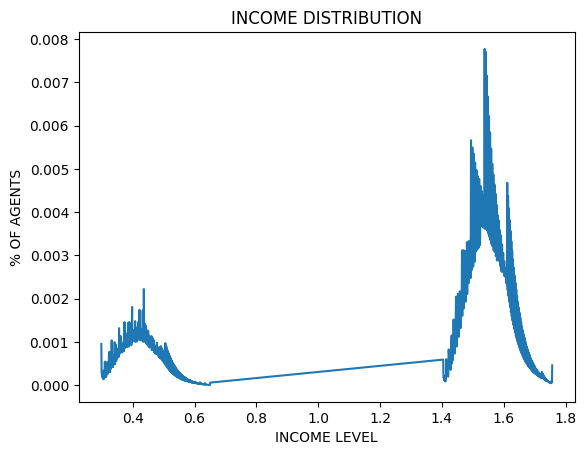

In [52]:
import matplotlib.pyplot as plt

h = param['h']
a_l = param['a_l']; a_u = param['a_u']; NA = param['NA'];
a = np.linspace(a_l, a_u, NA)


# calculate income distribution for each grid
income = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
# # transpose income
income = income.T
# # sorting the income after flattening "income"
# pinc, index = np.sort(income.flatten('F')), np.argsort(income.flatten('F'))
# plambda = mu.flatten('F')
# #

# sort with regard to the 1st argument of zip
zip_lists = zip(income.flatten('F'), mu.flatten('F'))
# sort upwards
zip_sort = sorted(zip_lists)
# unzip
pinc, pmu = zip(*zip_sort)

plt.plot(pinc, pmu)
plt.title('INCOME DISTRIBUTION')
plt.xlabel('INCOME LEVEL')
plt.ylabel('% OF AGENTS')

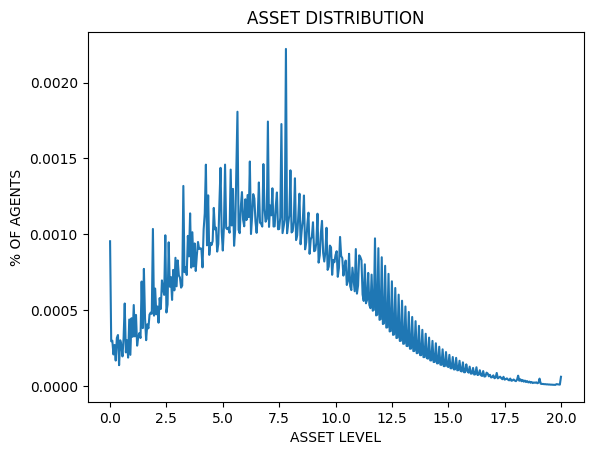

In [53]:
# 各所得ごとの割合を取得
income = np.array([(r*a + w*param['h'][0]), (r*a + w*param['h'][1])])
income = income.T
zip_lists = zip(a.flatten('F'), mu.flatten('F'))
zip_sort = sorted(zip_lists)
pinc, pmu = zip(*zip_sort)

# 分布をプロット
plt.plot(pinc, pmu)
plt.title('ASSET DISTRIBUTION')
plt.xlabel('ASSET LEVEL')
plt.ylabel('% OF AGENTS')
plt.show()

In [54]:
def solve_household_gs_tk(param, r, w, Tk):
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi']; delta = param['delta'];
    beta = param['beta']; sigma = param['sigma']; h = param['h']; NA = param['NA'];
    NH = param['NH'];

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)

    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons = w*h[ih] + (1.0 + r - Tk)*a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    v = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus_new = np.full((NA, NH), -10000)
    iaplus = np.full((NA, NH), -10000)
    reward = np.zeros((NA, NA, NH))

    test = 10
    while test != 0:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

        for ia in range(NA):
            for ih in range(NH):
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus_new[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(iaplus_new - iaplus)
        v = v_new
        iaplus = iaplus_new.copy()

    aplus = a[iaplus]

    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r - Tk)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

In [55]:
def get_distribution_tk(param, decisions, Tk):
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi'];
    NA = param['NA']; NH = param['NH'];
    iaplus = decisions[1]

    # Generate a linearly spaced vector of NA values between a_l and a_u
    a = np.linspace(a_l, a_u, NA)

    test = 10 # Initialize a test value to be greater than 10^-8
    phi = np.ones((NA, NH)) / NA / NH # Initialize the distribution phi to be uniform

    # Loop until the test value is less than 10^-8
    while test > 1e-8:
        phi_new = np.zeros((NA, NH)) # Initialize a new distribution phi_new to be all zeros
        # Loop over all values of a, h, and h'
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    # Update phi_new using the interpolation indices, blending coefficients, and probabilities
                    phi_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * phi[ia, ih]
        test = np.max(np.abs(phi_new - phi)) # Calculate the maximum difference between phi_new and phi
        phi = phi_new # Update phi to be phi_new

    # Apply capital income tax to the distribution phi
    phi *= np.exp(-Tk)

    return phi

In [56]:
def model_solution_tk(param, Tk):

    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH']

    phi = 0.2 # updating share
    toler = 1e-3 # warning: this doens't converge if tolerance is too small
    test = 10 # initial difference
    KK = 10.0 # initial capital

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:

        # Step 1
        # Calculate rental rate of capital and w from firm FOC
        w = (1 - alpha) * KK**alpha * HH**(-alpha)
        r = (alpha) * KK**(alpha - 1) * HH**(1 - alpha) - delta

        ####################################################
        # Step 2: Solving for households optimization (policy function of assets)
        ####################################################

        decisions = solve_household_gs_tk(param, r, w, Tk)
        aplus = decisions[0]


        ####################################################
        # Step 3: Loop for finding eq distribution and capital
        ####################################################

        # eq distribution

        mu = get_distribution_tk(param, decisions,Tk)

        # new aggregate capital

        KK_new = np.sum(mu*aplus)

        ####################################################
        # Loop for finding eq capital
        ####################################################

        # form metric and update KK

        test = abs((KK_new - KK)/KK) # loop until K converges
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi*KK_new + (1-phi)*KK # update K

    return decisions, r, w, KK, HH, mu

In [57]:
import matplotlib.pyplot as plt

Tk = 0.05

param = setPar()
(decisions, r, w, KK, HH, mu) = model_solution_tk(param, Tk)

# 結果の表示
print("定常状態均衡結果 (Tk=0.05):")
print("総資本 (K): {:.4f}".format(KK))
print("賃金 (w): {:.4f}".format(w))
print("利子率 (r): {:.4f}".format(r))

ITERATING ON KK

  metric    Kold      Knew
['0.8639', '10.0000', '1.3611']
['0.8295', '8.2722', '1.4104']
['0.7821', '6.8999', '1.5036']
['0.7205', '5.8206', '1.6271']
['0.6398', '4.9819', '1.7943']
['0.5230', '4.3444', '2.0722']
['0.3790', '3.8900', '2.4155']
['0.2132', '3.5951', '2.8288']
['0.0718', '3.4418', '3.1946']
['0.0091', '3.3924', '3.3614']
['0.0007', '3.3862', '3.3837']
定常状態均衡結果 (Tk=0.05):
総資本 (K): 3.3857
賃金 (w): 1.0499
利子率 (r): 0.0611


Text(0, 0.5, '% OF AGENTS')

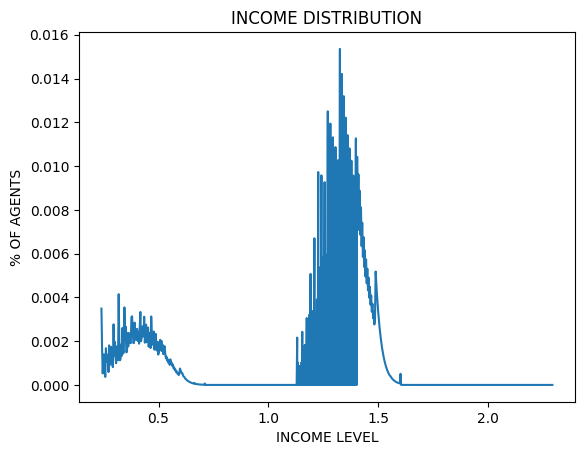

In [58]:
import matplotlib.pyplot as plt

h = param['h']
a_l = param['a_l']; a_u = param['a_u']; NA = param['NA']; NH = param['NH']
a = np.linspace(a_l, a_u, NA)

# calculate income distribution for each grid
income = np.array([(r * a * (1 - Tk) + w * h[0]), (r * a * (1 - Tk) + w * h[1])])

# # transpose income
income = income.T
# # sorting the income after flattening "income"
# pinc, index = np.sort(income.flatten('F')), np.argsort(income.flatten('F'))
# plambda = mu.flatten('F')
# #

# sort with regard to the 1st argument of zip
zip_lists = zip(income.flatten('F'), mu.flatten('F'))
# sort upwards
zip_sort = sorted(zip_lists)
# unzip
pinc_after, pmu_after = zip(*zip_sort)

plt.plot(pinc_after, pmu_after)
plt.title('INCOME DISTRIBUTION')
plt.xlabel('INCOME LEVEL')
plt.ylabel('% OF AGENTS')

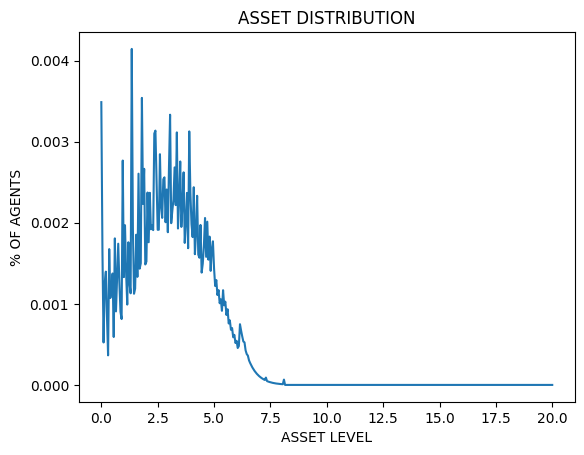

In [59]:
# 各所得ごとの割合を取得
income = np.array([(r * a * (1 - Tk) + w * h[0]), (r * a * (1 - Tk) + w * h[1])])
income = income.T
zip_lists = zip(a.flatten('F'), mu.flatten('F'))
zip_sort = sorted(zip_lists)
pinc_after, pmu_after = zip(*zip_sort)

# 分布をプロット
plt.plot(pinc_after, pmu_after)
plt.title('ASSET DISTRIBUTION')
plt.xlabel('ASSET LEVEL')
plt.ylabel('% OF AGENTS')
plt.show()

In [60]:
# モデルの設定
param = setPar()
(decisions, r, w, KK, HH, mu) = model_solution_tk(param, Tk=0)

# 初期の分布
income_before = np.array([(r * a * (1 - Tk) + w * h[0]), (r * a * (1 - Tk) + w * h[1])])
income_before = income_before.T
zip_lists_before = zip(income_before.flatten('F'), mu.flatten('F'))
zip_sort_before = sorted(zip_lists_before)
pinc_before, pmu_before = zip(*zip_sort_before)

# モデルの設定（Tk増加後）
(decisions_after, r, w, KK_after, HH, mu_after) = model_solution_tk(param, Tk=0.05)

# 増加後の分布
income_after = np.array([(r * a * (1 - Tk) + w * h[0]), (r * a * (1 - Tk) + w * h[1])])
income_after = income_after.T
zip_lists_after = zip(income_after.flatten('F'), mu_after.flatten('F'))
zip_sort_after = sorted(zip_lists_after)
pinc_after, pmu_after = zip(*zip_sort_after)

ITERATING ON KK

  metric    Kold      Knew
['0.5521', '10.0000', '4.4794']
['0.3771', '8.8959', '5.5410']
['0.1315', '8.2249', '7.1431']
['0.0205', '8.0085', '8.1730']
['0.0025', '8.0414', '8.0614']
['0.0015', '8.0454', '8.0337']
['0.0023', '8.0431', '8.0614']
['0.0031', '8.0467', '8.0219']
['0.0024', '8.0418', '8.0614']
['0.0091', '8.0457', '7.9724']
['0.0117', '8.0310', '8.1249']
['0.0083', '8.0498', '7.9828']
['0.0039', '8.0364', '8.0676']
['0.0005', '8.0426', '8.0386']
ITERATING ON KK

  metric    Kold      Knew
['0.8639', '10.0000', '1.3611']
['0.8295', '8.2722', '1.4104']
['0.7821', '6.8999', '1.5036']
['0.7205', '5.8206', '1.6271']
['0.6398', '4.9819', '1.7943']
['0.5230', '4.3444', '2.0722']
['0.3790', '3.8900', '2.4155']
['0.2132', '3.5951', '2.8288']
['0.0718', '3.4418', '3.1946']
['0.0091', '3.3924', '3.3614']
['0.0007', '3.3862', '3.3837']


In [61]:
def gini_coefficient(pinc, pmu):

    # ローレンツ曲線の面積
    total_area = np.trapz(pmu, pinc)

    # 均等分配線の下の面積
    equal_area = 0.5

    # ジニ係数の計算
    gini = (equal_area - total_area) / equal_area

    return gini

# 初期の所得格差
gini_before = gini_coefficient(pinc_before, pmu_before)

# 増加後の所得格差
gini_after = gini_coefficient(pinc_after, pmu_after)

# 所得格差の変化
gini_change = gini_after - gini_before


# GDPの変化を計算
GDP_before = w * HH + r * KK
GDP_after = w * HH + r * KK_after
GDP_change_redistributed = (GDP_after - GDP_before) / GDP_before * 100

# 結果を表示
print("所得格差(ジニ係数)の変化 : {:.4f}".format(gini_change))
print("GDP変化率 : {:.2f}%".format(GDP_change_redistributed))

所得格差(ジニ係数)の変化 : -0.0018
GDP変化率 : -20.08%
